## Library imports:

In [1]:
import sys

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
from sklearn.manifold import TSNE

## Local Imports:
Modules (scripts) located in the same/parent folder of this python notebook. Classes and functions I have written to load and process mini datasets from CSVs, construct and train artificial neural networks, and perform clustering algorithms.

In [2]:
sys.path.append('../')  # add parent folder to path
import mini_processing as minipro
import torch_clustering as clorch
import cluster_ae_builds as builds

## Set matlibplot style (colours etc.):

In [3]:
mpl.style.use('seaborn')

## Load minis dataset:
Load in sets of mini recordings (clipped with set amount of head and tail points relative to the detected mEPSC peak) stored in CSVs. The files in the target folder should be have consistent naming according to their condition (e.g. GABA only) with a trailing number (ex: `GABA0.csv`).
```css
Pipeline:
> load all of the CSVs contained in the given folder
> remove linear trend from the recording offset
> clip traces, removing excess leading and trailing points
> flip negative currents to positive
> normalize
```

In [4]:
datapath = "/media/geoff/Data/vj_minis/"

length =  767
dt = .1
prefixes = ["GABA", "Gly", "GlyKO", "mixed"]
join_sets = ["GABA", "GlyKO"]
# prefixes = ["Gly", "GlyKO", "GABA"]
# join_sets = []
# norm_mode = "group_mean"
norm_mode = "feature"
only = ""
minis, labels, label_strs = minipro.get_minis_dataset(
    datapath,
    prefixes,
    start=350,
    end=350+length,
    norm=norm_mode,
    join=join_sets,
    only=only,
    balance=True,
)

# number of target clusters (used throughout notebook)
K = 2

## Build covolutional clustering encoder network, and fit:
In order to reduce the complex waveform of current over time for each mini into a smaller number of clusterable representative values, we will train an artificial neural network to extract arbitrary features for us. Although said features will not be human understandable, the hope is that they are *descriptive* enough of the input data that we can delineate samples that have come from separate distributions. To push our network towards successfully producing representations of the input data that will allow us to so, we will explicitly incentivize it to lump samples into clusters.

A common technique for **feature extraction** from the "unstructured" (non-tabular) input data is learned convolutional filtering. In machine learning applications, **convolution** is actually usually implemented as **cross-correlation**, however since the kernels are learned anyway, there is no practical difference. By sliding a small kernel over the temporal dimension, rather than learning an independent weight for each point in time, our feature extraction can be much more robust to variability since it does not rely on events occuring at the exact same location in order to be detected. Also, it dramatically cuts down on the number of parameters (weights) our network has to learn.

![title](crosscorrelation.gif)

The first stage involves several layers of convolutional filtering. The original input is a one channel recording over time, we then apply many filters (initialized randomly and learned), whose outputs are combined and serve as the input to the next layer of convolutions. The data is reduced over the time dimension by striding the convolutions (filter kernel moves >1 point with each step). This results in kernels filtering for larger temporal features as the data is transformed by the network.

![title](conv1d_manychannel.png)

The output from the last convolutional layer is flattened into a feature vector and fed in to a fully-connected layer for further dimensional reduction. Then, all of the transformations are mirrored (using the same weights), to re-create the input.

![title](simple_schematic.png)

The cost function used to train the network is a weighted combination of the mean squared-error (MSE) of the input vs the output construct, and the difference between current cluster quality and a more optimal clustering. With each batch of samples passed through the network, the weights used for convolution and matrix multiplication are adjusted to reduce cost function using gradiet descent.

epoch: 0 n_batches: 16
cost: 0.148506
epoch: 1 n_batches: 16
cost: 0.047563
epoch: 2 n_batches: 16
cost: 0.034896
epoch: 3 n_batches: 16
cost: 0.028584
epoch: 4 n_batches: 16
cost: 0.027513
epoch: 5 n_batches: 16
cost: 0.030277
epoch: 6 n_batches: 16
cost: 0.028045
epoch: 7 n_batches: 16
cost: 0.027175
epoch: 8 n_batches: 16
cost: 0.026800
epoch: 9 n_batches: 16
cost: 0.025660
epoch: 10 n_batches: 16
cost: 0.024602
epoch: 11 n_batches: 16
cost: 0.025416
epoch: 12 n_batches: 16
cost: 0.024045
epoch: 13 n_batches: 16
cost: 0.023840
epoch: 14 n_batches: 16
cost: 0.022933
epoch: 15 n_batches: 16
cost: 0.022562
epoch: 16 n_batches: 16
cost: 0.022666
epoch: 17 n_batches: 16
cost: 0.020413
epoch: 18 n_batches: 16
cost: 0.021820
epoch: 19 n_batches: 16
cost: 0.021397
epoch: 20 n_batches: 16
cost: 0.020406
epoch: 21 n_batches: 16
cost: 0.024853
epoch: 22 n_batches: 16
cost: 0.020642
epoch: 23 n_batches: 16
cost: 0.020610
epoch: 24 n_batches: 16
cost: 0.019930
epoch: 25 n_batches: 16
cost: 0.020

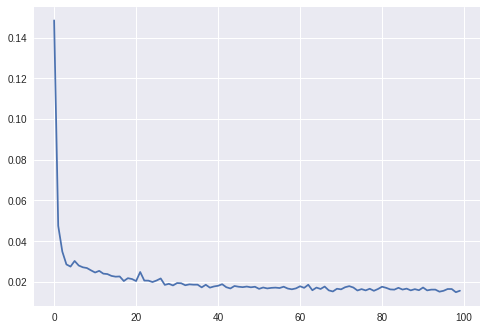

In [5]:
# build network
autoencoder = builds.ae_build_14()

# fit network
autoencoder.fit(
    minis, K, lr=1e-3, epochs=100, cluster_alpha=.05,
    clust_mode='KLdiv', show_plot=True
)

## Get dimensionally reduced representation of the data:
Input the minis, and take the transformation generated by the front half (encoder) of the network. We'll use that for clustering and displaying the data in a human comprehendable (2-dimensional) format.

In [6]:
reduced = autoencoder.get_reduced(minis)

In [7]:
centres, clusters, _ = clorch.hard_kmeans(torch.from_numpy(reduced), K)
centres, clusters = centres.cpu().numpy(), clusters.cpu().numpy()
counts, ratios = clorch.cluster_counts(clusters, labels)

## Assign cluster labels to each sample using K-means:

Here we calculate the ratio of total population of each mini-set (column) that belongs to each cluster (row). Looking at the proportion of each class of events that each cluster accounts for can give us an estimate of the *accuracy* of the clustering. If most of the events of a particular class end up in a particular cluster, without a significant amount of contamination by other classes, our sorting will have had some success.

In [8]:
print(
    "Cluster Breakdown:\n    "+(' '*3).join(label_strs)+'\n',
    np.round(ratios, decimals=3)
)

Cluster Breakdown:
    GABA   Gly   mixed
 [[0.967 0.096 0.406]
 [0.033 0.904 0.594]]


## Further reduce the dimensionality of the encoders output:
If the encoder is not restricted to representing the data with 2 values (think xy coordinates), use t-SNE (t-distributed stochastic neighbour embedding) to embed the N-dimensional feature vector into 2 dimensions.

We also want to reduce the dimensionality of the cluster centres provided by our clustering algorithm (K-means), so we temporarily concatenate them to the mini dataset for the t-SNE run.

In [9]:
if reduced.shape[1] > 2:
    # also, reduce the cluster centres (TSNE must do all at once)
    reduced_centres = TSNE(
        n_components=2, perplexity=75, learning_rate=400, n_iter=1000
    ).fit_transform(np.concatenate([reduced, centres], axis=0))
    
    # split samples and centres
    reduced = reduced_centres[:-centres.shape[0], :]
    centres = reduced_centres[-centres.shape[0]:, :]
    
    del reduced_centres

## Plot scatters of the reduced mini waveforms:
Now that we have turned our minis from recordings to single points in a 2-dimensional coordinate space, we can display them in a scatter plot. Here, we have the same data presented twice, but with different labelling. 

On the left, each sample is labelled according to the dataset that it originated from (e.g. isolated events of a particular type, or mixed). On the right, the labels are given by running a clustering algorithm on the internal representation of the auto-encoder model.

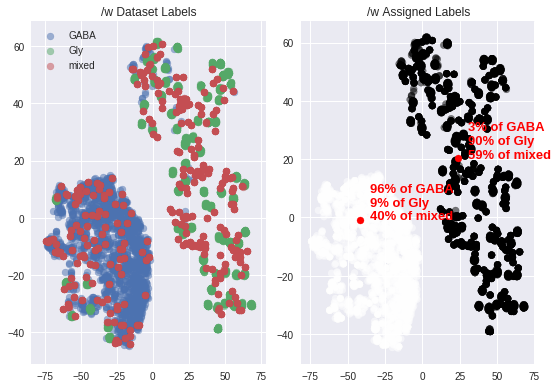

In [10]:
fig, ax = plt.subplots(1, 2)

# plot samples in 2d coordinate space, coloured by their true label
for label in np.unique(labels):
    grp = reduced[labels == label]
    ax[0].scatter(grp[:, 0], grp[:, 1], label=label_strs[label], alpha=.5)

# plot same samples, but coloured by their assigned cluster
ax[1].scatter(reduced[:, 0], reduced[:, 1], c=clusters, alpha=.5)

# plot cluster centres, with annotations stating what percentage of the
# total population of each label resides there
for (cx, cy), clstpop in zip(centres, ratios*100):
    ax[1].scatter(cx, cy, c='red')
    note = '\n'.join([
        "%d%% of %s" % (pop, lbl)
        for lbl, pop in zip(label_strs, clstpop)
    ])
    ax[1].annotate(
        note, (cx, cy), (10, 0), textcoords='offset pixels', c='red',
        fontsize=13, weight='heavy'
    )

ax[0].legend()
ax[0].set_title("/w Dataset Labels")
ax[1].set_title("/w Assigned Labels")

fig.tight_layout()

## Use the assigned labels to group minis and calculate prototypical examples:

In [11]:
proto_events = np.concatenate([
    np.mean(minis[clusters == i], axis=0)
    for i in np.unique(clusters)
], axis=0)

Normalize the proto-events to bring them into the same scales for display. 

In [12]:
# standard normalization (mean=0, var=1)
proto_norms = (
    proto_events - proto_events.mean(axis=1, keepdims=True)
) / proto_events.std(axis=1, keepdims=True)

# normalize on a 0 -> 1 scale (feature scaling)
proto_stretch = minipro.min_max_scaling(proto_events)

Plot calculated proto-events.

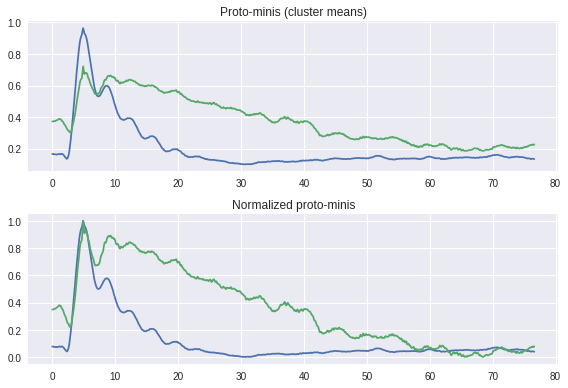

In [13]:
xaxis = np.arange(proto_events.shape[1]) * dt

fig1, ax1 = plt.subplots(2, 1)
ax1[0].plot(xaxis, proto_events.T)
ax1[0].set_title("Proto-minis (cluster means)")
ax1[1].plot(xaxis, proto_stretch.T)
ax1[1].set_title("Normalized proto-minis")
fig1.tight_layout()

## Average the events together according to their actual labels:

In [14]:
average_events = np.concatenate([
    np.mean(minis[labels == i], axis=0)
    for i in np.unique(labels)
], axis=0)

Normalize the average-events to bring them into the same scales for display.

In [15]:
# standard normalization (mean=0, var=1)
average_norms = (
    average_events - average_events.mean(axis=1, keepdims=True)
) / average_events.std(axis=1, keepdims=True)

# normalize on a 0 -> 1 scale (feature scaling)
average_stretch = minipro.min_max_scaling(average_events)

Plot calculated average-events.

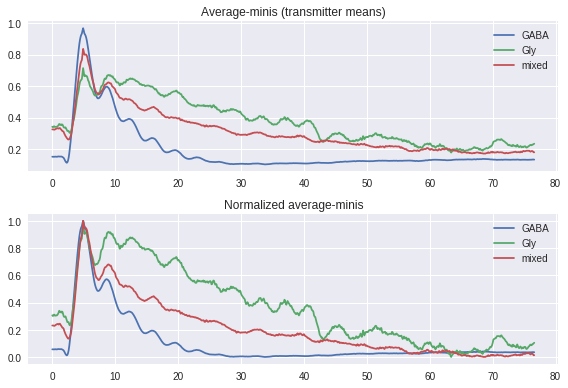

In [16]:
xaxis = np.arange(average_events.shape[1]) * dt

fig2, ax2 = plt.subplots(2, 1)

for i, event in enumerate(average_events):
    ax2[0].plot(xaxis, event, label=label_strs[i])
ax2[0].legend()
ax2[0].set_title("Average-minis (transmitter means)")

for i, event in enumerate(average_stretch):
    ax2[1].plot(xaxis, event, label=label_strs[i])
ax2[1].legend()
ax2[1].set_title("Normalized average-minis")

fig2.tight_layout()

## Generate and plot example reconstructions of the inputs:
In order to learn to represent the input signals in a low-dimensional feature vector space, our model is trained not only to reduce the signals, but to re-build them. The weights used to manipulate the data as it is propagated through the network are adjusted to minimize the difference between the reconstructions and the original data. 

Since this model is also given the task of ensuring the reduced representations fall into a certain number of clusters, the quality of reconstructions may suffer somewhat. In general, the greater the dimensionality we allow the network to represent the data with in it's centre (between the encoder and decoder), and the less we punish the model for not producing clean clusters, the better the reconstructions will be (but the looser and less clear the resulting clusters will be).

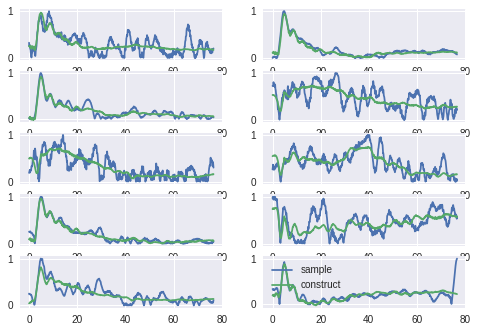

In [17]:
autoencoder.reconstruct(minis, batch_sz=10, dt=.1)

# Alternative non-DeepLearning approach:
Below, we'll use a set of "engineered" features as our dimensions, rather than those created in the centre of the deep clustering auto-encoder network used above. These will be simply (automatically) calculated exponential rise and decay, linear (number of points between 20-80% thresholds) rise and decay, and amplitude/size metrics (peak, area, and peak divided by area).

## Re-load mini dataset, less-cropped for fitting:

In [18]:
datapath = "/media/geoff/Data/vj_minis/"
long_minis, labels, label_strs = minipro.get_minis_dataset(
    datapath,
    prefixes,
    start=0,
    end=1500,
    norm=norm_mode,
    join=join_sets,
    only=only,
    balance=True,
)

# remove channel dimension -> shape (N, T)
long_minis = np.squeeze(long_minis)

## Build metric set using exponential fitting, linear rise/decay times, and peak/area measurements

In [39]:
# split waves on peak and calc rise/decay metrics for head and tail of each event
peak_loc = 400
all_metrics = {}
all_metrics["exp"] = np.array([
    minipro.get_exp_fits(mini, peak_loc)
    for mini in long_minis
])

all_metrics["time"] = np.array([
    minipro.get_rise_decay(mini, peak_loc, kernel_sz=3)
    for mini in long_minis
])

all_metrics["simple"] = np.stack([
    long_minis.max(axis=1),
    long_minis.sum(axis=1),
    long_minis.max(axis=1) / long_minis.sum(axis=1),
], axis=1)

metrics = np.concatenate([
    all_metrics["exp"],
    all_metrics["time"],
    all_metrics["simple"],
], axis=1)

# swap in to test metric sets in isolation
# metrics = all_metrics["exp"]
# metrics = all_metrics["time"]
# metrics = all_metrics["simple"]

# normalize each dimension over population of samples
metrics = minipro.norm_dimensions(metrics)

## Example of exponential fitting:

This strategy is far from fool-proof, but lumped in with other descriptive metrics, it can provide clustering algorithms, such as K-means, another dimension with which to discriminate events.

head params:
y0: 1.023, tau: 5.504, bias: 0.144
tail params:
y0: 0.807, tau: 20.067, bias: 0.191


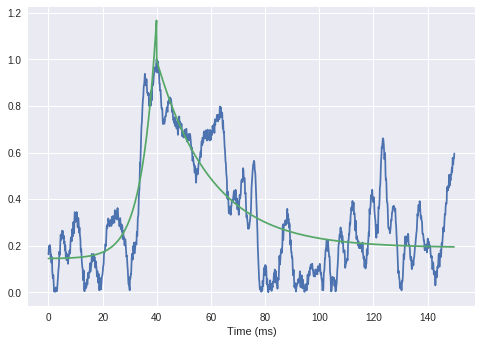

In [40]:
sample = long_minis[3006, :]
xaxis = np.arange(sample.shape[0]) * dt

h_y0, h_tau, h_b, t_y0, t_tau, t_b = minipro.get_exp_fits(sample, 400)

head_x = np.arange(400)
tail_x = np.arange(sample.shape[0] - 400)

head_line = np.flip(minipro.expfun(head_x, h_y0, h_tau, h_b))
tail_line = minipro.expfun(tail_x, t_y0, t_tau, t_b)

fit_line = np.concatenate([head_line, tail_line[1:]]) # skip dupe point

plt.plot(xaxis, sample)
plt.plot(xaxis[:-1], fit_line)
plt.xlabel("Time (ms)")

print("head params:\ny0: %.3f, tau: %.3f, bias: %.3f" % (h_y0, h_tau*dt, h_b))
print("tail params:\ny0: %.3f, tau: %.3f, bias: %.3f" % (t_y0, t_tau*dt, t_b))

## Exponential fit parameters for each mini popultation:

In [41]:
medians_dict = {
    metric: {
        label_strs[i]: np.round(
            np.median(values[labels == i], axis=0), decimals=5
        )
        for i in range(len(label_strs))
    }
    for metric, values in all_metrics.items()
}

print("RISE:")
print("\t\ty0\ttau\tbias")
for trans, exp_metrics in medians_dict["exp"].items():
    exp_metrics[1] = exp_metrics[1] * dt  # quick fix
    print("\t%s:\t%.3f\t%.3f\t%.3f" % (trans, *exp_metrics[:3]))

print("DECAY:")
print("\t\ty0\ttau\tbias")
for trans, exp_metrics in medians_dict["exp"].items():
    exp_metrics[4] = exp_metrics[4] * dt  # quick fix
    print("\t%s:\t%.3f\t%.3f\t%.3f" % (trans, *exp_metrics[3:6]))

RISE:
		y0	tau	bias
	GABA:	1.083	1.110	0.133
	Gly:	0.349	0.937	0.387
	mixed:	0.601	0.885	0.288
DECAY:
		y0	tau	bias
	GABA:	0.837	5.994	0.103
	Gly:	0.608	18.277	0.181
	mixed:	0.724	10.076	0.134


## Exponential Rise vs Decay scatter:

(0, 100)

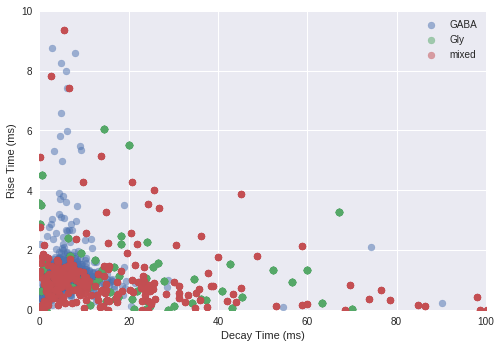

In [42]:
for i in np.unique(labels):
    grp = all_metrics["exp"][labels == i]
    plt.scatter(
        grp[:, 4]*dt, grp[:, 1]*dt, label=label_strs[i], alpha=.5
    )
plt.legend()
plt.ylabel("Rise Time (ms)")
plt.xlabel("Decay Time (ms)")
plt.ylim(0, 10)
plt.xlim(0, 100)

## Linear Rise/Decay durations in number of points:

Also, tested out a very simple points between thresholds on rise and decay. Does not work reliably in every dataset tested.

In [46]:
print("RISE (pts):")
for trans, time_metrics in medians_dict["time"].items():
    spaces = " " * (6 - len(trans))
    print("\t%s:%s%d" % (trans, spaces, time_metrics[0]))

print("DECAY (pts):")
for trans, time_metrics in medians_dict["time"].items():
    spaces = " " * (6 - len(trans))
    print("\t%s:%s%d" % (trans, spaces, time_metrics[1]))

RISE (pts):
	GABA:  18
	Gly:   0
	mixed: 13
DECAY (pts):
	GABA:  67
	Gly:   0
	mixed: 47


## Linear Rise vs Decay scatter:

(0, 40)

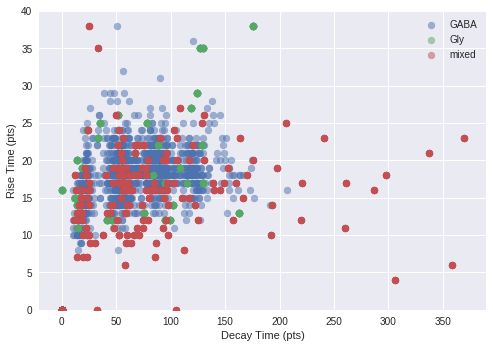

In [44]:
for i in np.unique(labels):
    grp = all_metrics["time"][labels == i]
    plt.scatter(grp[:, 1], grp[:, 0], label=label_strs[i], alpha=.5)
plt.legend()
plt.ylabel("Rise Time (pts)")
plt.xlabel("Decay Time (pts)")
plt.ylim(0, 40)

## Peak vs Area scatter:

(0, 1000)

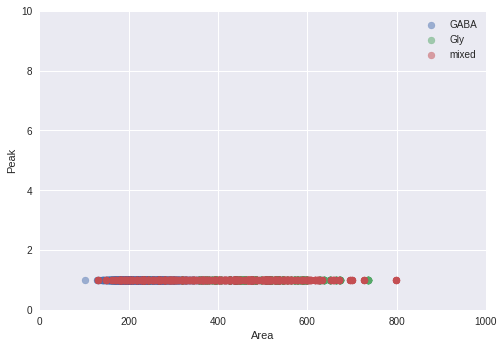

In [25]:
# NOTE: not so complete with data that is feature normalized
for i in np.unique(labels):
    grp = all_metrics["simple"][labels == i]
    plt.scatter(grp[:, 1], grp[:, 0], label=label_strs[i], alpha=.5)
plt.legend()
plt.ylabel("Peak")
plt.xlabel("Area")
plt.ylim(0, 10)
plt.xlim(0, 1000)

## Cluster samples based on extracted metrics:

Attempt K-means clustering on these engineered metrics, and reduce to two dimensions for visualization with t-SNE.

In [26]:
# cluster with K-means
centres, clusters, _ = clorch.hard_kmeans(torch.from_numpy(metrics), K)
centres, clusters = centres.cpu().numpy(), clusters.cpu().numpy()
counts, ratios = clorch.cluster_counts(clusters, labels)

print(
    "Cluster Breakdown:\n    "+(' '*3).join(label_strs)+'\n',
    np.round(ratios, decimals=3)
)

# reduce dimensionality for display using t-SNE
reduced_centres = TSNE(
    n_components=2, perplexity=60, learning_rate=400, n_iter=1000
).fit_transform(np.concatenate([metrics, centres], axis=0))
# split samples and centres
reduced = reduced_centres[:-centres.shape[0], :]
centres = reduced_centres[-centres.shape[0]:, :]
del reduced_centres

Cluster Breakdown:
    GABA   Gly   mixed
 [[0.13  0.932 0.496]
 [0.87  0.068 0.504]]


Plot t-SNE reduced human engineered metrics in scatter format. True dataset labels side-by-side with K-means assigned labels.

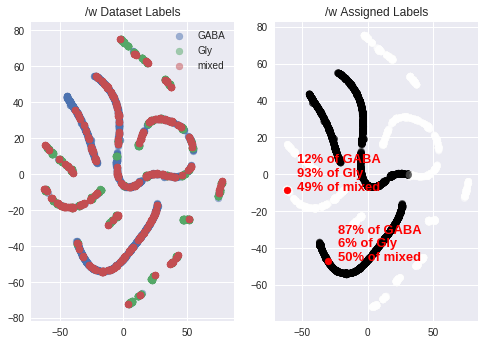

In [27]:
fig3, ax3 = plt.subplots(1, 2)

# plot samples coloured by their true label
for label in np.unique(labels):
    grp = reduced[labels == label]
    ax3[0].scatter(
        grp[:, 0], grp[:, 1], label=label_strs[label], alpha=.5
    )

# plot same samples, but coloured by their assigned cluster
ax3[1].scatter(reduced[:, 0], reduced[:, 1], c=clusters, alpha=.5)

# plot cluster centres, with annotations stating what percentage of the
# total population of each label resides there
for (cx, cy), clstpop in zip(centres, ratios*100):
    ax3[1].scatter(cx, cy, c='red')
    note = '\n'.join([
        "%d%% of %s" % (pop, lbl) for lbl, pop in zip(label_strs, clstpop)
    ])
    ax3[1].annotate(
        note, (cx, cy), (10, 0), textcoords='offset pixels', c='red',
        fontsize=13, weight='heavy'
    )

ax3[0].legend()
ax3[0].set_title("/w Dataset Labels")
ax3[1].set_title("/w Assigned Labels")

fig.tight_layout()

## Principal component analysis of extracted metrics:

Plot scatter of top two information rich dimensions created by PCA, coloured by dataset label.

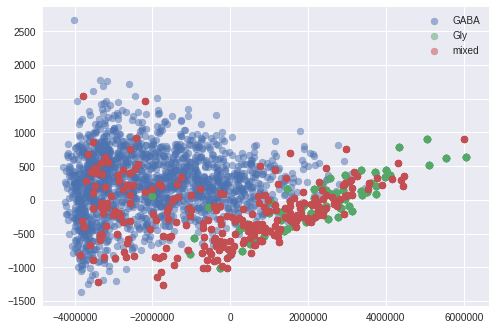

In [28]:
from sklearn.decomposition import PCA
reduced = PCA().fit_transform(metrics)

for i in np.unique(labels):
    grp = reduced[labels == i]
    plt.scatter(grp[:, 0], grp[:, 1], label=label_strs[i], alpha=.5)
plt.legend()

## Clustering on simple cross-correlation coefficients:

Correlations between each mini wave snippet (sorted).

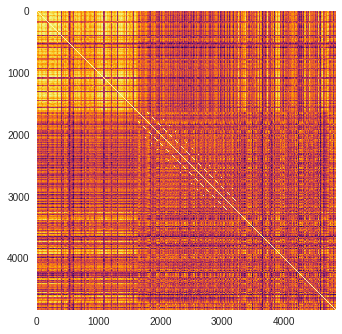

In [29]:
corrmat = np.corrcoef(long_minis)

plt.imshow(corrmat, cmap='inferno')
plt.grid(False)

Attempt K-means clustering on these wave-to-wave correlations, and reduce to two dimensions for visualization.

Cluster Breakdown:
    GABA   Gly   mixed
 [[0.864 0.178 0.436]
 [0.136 0.822 0.564]]


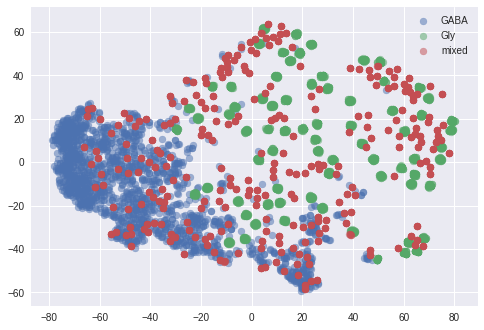

In [31]:
centres, clusters, _ = clorch.hard_kmeans(torch.from_numpy(corrmat), K)
centres, clusters = centres.cpu().numpy(), clusters.cpu().numpy()
counts, ratios = clorch.cluster_counts(clusters, labels)

print(
    "Cluster Breakdown:\n    "+(' '*3).join(label_strs)+'\n',
    np.round(ratios, decimals=3)
)

# PCA to reduce dimensions before t-SNE to make the computation lighter
reduced_centres = PCA().fit_transform(np.concatenate([corrmat, centres], axis=0))

# reduce dimensionality for display using t-SNE
reduced_centres = TSNE(
    n_components=2, perplexity=60, learning_rate=400, n_iter=1000
).fit_transform(reduced_centres[:, :100])
# split samples and centres
reduced = reduced_centres[:-centres.shape[0], :]
centres = reduced_centres[-centres.shape[0]:, :]
del reduced_centres

for label in np.unique(labels):
    grp = reduced[labels == label]
    plt.scatter(grp[:, 0], grp[:, 1], label=label_strs[label], alpha=.5)
plt.legend()

Replotting true-labels side-by-side with assigned cluster labels.

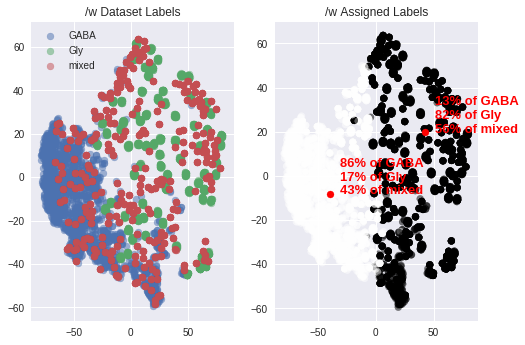

In [32]:
fig3, ax3 = plt.subplots(1, 2)

# plot samples coloured by their true label
for label in np.unique(labels):
    grp = reduced[labels == label]
    ax3[0].scatter(
        grp[:, 0], grp[:, 1], label=label_strs[label], alpha=.5
    )

# plot same samples, but coloured by their assigned cluster
ax3[1].scatter(reduced[:, 0], reduced[:, 1], c=clusters, alpha=.5)

# plot cluster centres, with annotations stating what percentage of the
# total population of each label resides there
for (cx, cy), clstpop in zip(centres, ratios*100):
    ax3[1].scatter(cx, cy, c='red')
    note = '\n'.join([
        "%d%% of %s" % (pop, lbl) for lbl, pop in zip(label_strs, clstpop)
    ])
    ax3[1].annotate(
        note, (cx, cy), (10, 0), textcoords='offset pixels', c='red',
        fontsize=13, weight='heavy'
    )

ax3[0].legend()
ax3[0].set_title("/w Dataset Labels")
ax3[1].set_title("/w Assigned Labels")

fig.tight_layout()

## Notes:

In this Glycine-GABA mini dataset, the minis were quite seperable, likely owing to their drammatically different temporal (shape) characteristics. Empirically, applying feature-scaling (0 to 1 normalization) seemed to lead to more accurate clustering. The deep clustering convolutional network that I put together out performs other non-deep learning approaches that I tested, however not as drammatically as in the much more ambigious ACh-GABA dataset that I have also experimented with.

```Example run (ratios of each dataset belonging to K-means clusters):
                GABA     Gly    mixed
   cluster 1    0.967   0.096   0.406
   cluster 2    0.033   0.904   0.594
```

Here >95% of the GABA events are sorted into a cluster that only contains ~10% of the glycine events. Conversely, The "glycine" cluster contains the remaining ~90% of glycine minis, and only ~3% of the GABA minis. Based on this clean breakdown, the assignment of ~40% of the mixed (un-labelled / un-confirmable transmitter) events to the GABA cluster and ~60% to the glycine cluster gives us an estimate of their relative frequencies in the physiological conditions in which they were recorded. 